In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn
import pickle
import math
import random
from sklearn import linear_model
from PIL import Image, ImageDraw

def Grey(filename, size = 25):
    img = Image.open( filename.rstrip() ).convert('LA')
    img = img.resize((size,size), Image.ANTIALIAS)
    return img
        
def get_segs(verts):
    segs = []
    for i in xrange(1,len(verts)):
        segs.append([verts[i-1], verts[i]])
    segs.append([verts[0], verts[-1]])
    return segs

def seg_xs_ys(seg):
    seg_arr = np.asarray(seg)
    xs = seg_arr[:,0:1]
    ys = seg_arr[:,1:2]
    return xs, ys
    
    
def sample_pts_from_line_seg(xs, ys):
    
    model = linear_model.LinearRegression()
    model.fit(xs, ys)

    line_x = np.arange(np.min(xs), np.max(xs), 3)
    line_y = model.predict(line_x[:, np.newaxis])
    
    return line_x, line_y

def add_noise(points, noise_min = -3, noise_max = 3):
    noise = np.asarray([random.randint(noise_min, noise_max) for i in xrange(points.shape[0])])
    return points + noise

def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :

    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max):
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x


def isTooClose(center_pts, p_new):
    for p_used in center_pts:
        dist = np.linalg.norm(p_used-p_new)
        if dist < 100:
            return True
    return False
    

def getNewCenterPoint(center_pts, p_min=70, p_max=930):
    ctrx = random.randint(p_min,p_max)
    ctry = random.randint(p_min,p_max)
    p_new = np.array((ctrx ,ctry))
    
    if len(center_pts) == 0:
        center_pts.append(p_new)
        return center_pts
    
    while isTooClose(center_pts, p_new):
        ctrx = random.randint(p_min,p_max)
        ctry = random.randint(p_min,p_max)
        p_new = np.array((ctrx ,ctry))
    
    center_pts.append(p_new)
    return center_pts

In [2]:
CLASSES = 5
TOT_PER_CLASS = 5000

for N in tqdm(xrange(1,CLASSES+1)):
    for j in xrange(1,TOT_PER_CLASS+1):
        center_pts = []
        polygons = []
        for n in xrange(N):
            center_pts = getNewCenterPoint(center_pts)
            x, y = center_pts[-1][0], center_pts[-1][1]
            radius = random.randint(30,70)
            v = random.randint(4,6)
            s = random.random()
            verts = generatePolygon( ctrX=x, ctrY=y, aveRadius=radius, irregularity=s, spikeyness=0, numVerts=v)
            polygons.append(verts)

        all_xs = []
        all_ys = []


        for poly in polygons:
            segs = get_segs(poly)
            for s in segs:
                xs, ys = seg_xs_ys(s)
                
                #check for non-verticle
                if xs[0] == xs[1]:
                    xs[1] += 1
                line_x, line_y = sample_pts_from_line_seg(xs, ys)
                #plt.scatter(line_x, line_y, color=colors[c])

                line_x_noise = add_noise(line_x, noise_min = -5, noise_max = 5)
                line_y_noise = add_noise(line_y[:,0], noise_min = -5, noise_max = 5)

                all_xs.extend(line_x_noise)
                all_ys.extend(line_y_noise)

                #plt.scatter(line_x_noise, line_y_noise, color="black")

        all_points = []
        all_points.append(all_xs)
        all_points.append(all_ys)

        all_points = np.asarray(all_points).T

        poly_img = np.ones((1000,1000))
        for i in xrange(all_points.shape[0]):
            x = all_points[i,0]
            y = all_points[i,1]
            x = clip(x, 0, 999)
            y = clip(y, 0, 999)
            poly_img[x,y] = 0

        im = Image.fromarray(poly_img.astype('uint8')*255) 
        #plt.imshow( im)
        #plt.show()
        i
        #display(filename='poly.png')
########SAVE FILES HERE - OUT OF PRECAUTION TO NOT OVER WRTIE###############
#         im.save('temp.png')
#         im = Grey('temp.png')
#         im.save('sample_maps/map-' + str(N) +'/sample-'+str(j)+'.png')

############################################################################

        #display(filename='poly-grey.png')


100%|██████████| 5/5 [33:46<00:00, 412.95s/it]


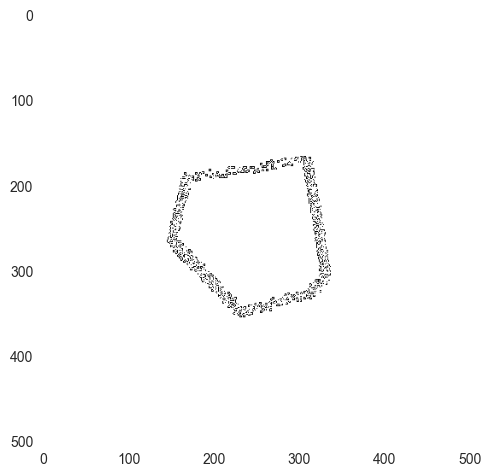

1492


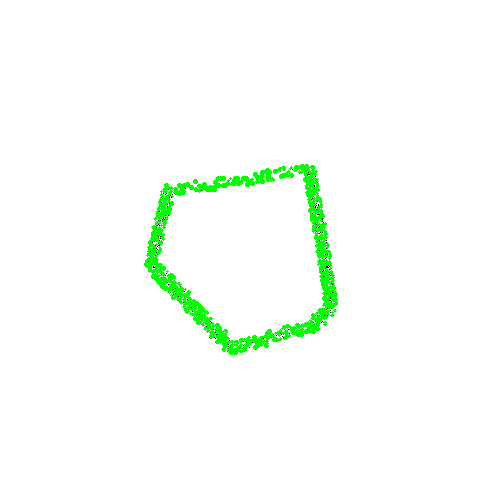

In [326]:
import sys

sys.path.append('/usr/local/lib/python2.7/site-packages')

import cv2
import numpy as np

img = cv2.imread('poly.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
plt.imshow( edges)
plt.show()

minLineLength = 1000
maxLineGap = -100
lines = cv2.HoughLinesP(edges,1,np.pi/180,-1000,minLineLength,maxLineGap)
print len(lines)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imwrite('poly_hough_P.png',img)
display(filename='poly_hough_P.png')







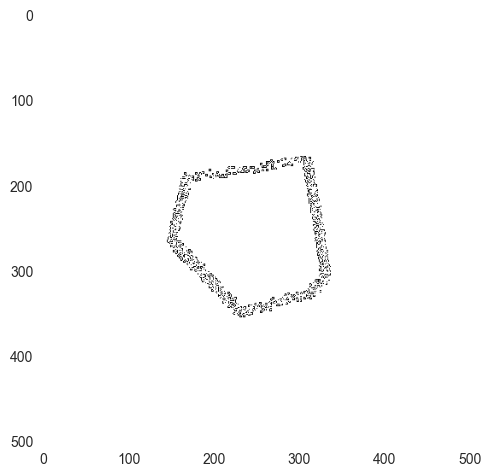

216


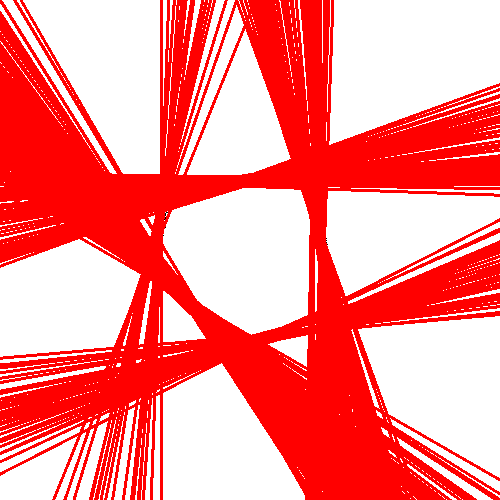

In [327]:
img = cv2.imread('poly.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
plt.imshow( edges)
plt.show()


lines = cv2.HoughLines(edges,1,np.pi/180,30)
print len(lines)
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)


cv2.imwrite('poly_hough.png',img)
display(filename='poly_hough.png')

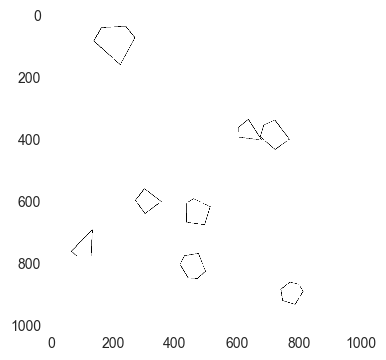

In [452]:
from IPython.display import Image as display
display(filename='poly.png')


#TO SHOW THE IMAGE OF POLYGONS BEFORE THEY GET SAMPLED INTO POINTS
black = (0,0,0)
white=(255,255,255)
im = Image.new('RGB', (1000, 1000), white)
imPxAccess = im.load()
draw = ImageDraw.Draw(im)

for poly in polygons:
    

    tupVerts = map(tuple,poly)


    # either use .polygon(), if you want to fill the area with a solid colour
    draw.polygon( tupVerts, outline=black,fill="white" )

    # or .line() if you want to control the line thickness, or use both methods together!
    draw.line( tupVerts+[tupVerts[0]], width=2, fill=black )

plt.imshow( im)
plt.show()



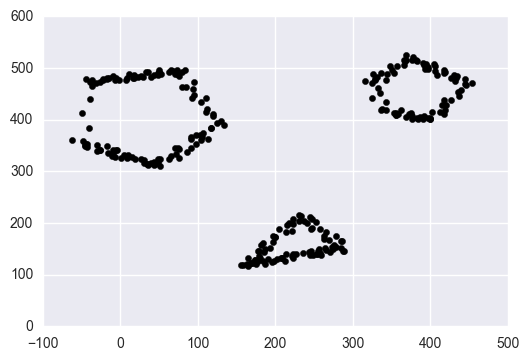

In [53]:
center_pts = []
polygons = []
for n in xrange(3):
    center_pts = getNewCenterPoint(center_pts, p_min=20, p_max=480)
    x, y = center_pts[-1][0], center_pts[-1][1]
    radius = random.randint(50,100)
    v = random.randint(3,6)
    #v = 3
    s = random.random()
    verts = generatePolygon( ctrX=x, ctrY=y, aveRadius=radius, irregularity=s, spikeyness=0, numVerts=v)
    polygons.append(verts)

all_xs = []
all_ys = []


for poly in polygons:
    segs = get_segs(poly)
    for s in segs:
        xs, ys = seg_xs_ys(s)

        #check for non-verticle
        if xs[0] == xs[1]:
            xs[1] += 1
        line_x, line_y = sample_pts_from_line_seg(xs, ys)
        #plt.scatter(line_x, line_y, color=colors[c])

        line_x_noise = add_noise(line_x, noise_min = -10, noise_max = 10)
        line_y_noise = add_noise(line_y[:,0], noise_min = -5, noise_max = 5)

        all_xs.extend(line_x_noise)
        all_ys.extend(line_y_noise)

        #plt.scatter(line_x_noise, line_y_noise, color="black")

all_points = []
all_points.append(all_xs)
all_points.append(all_ys)

all_points = np.asarray(all_points).T

plt.scatter(all_points[:,0], all_points[:,1], color="black")
plt.show()
# with open("auto-sample-map.dat", "wb") as f:
#     pickle.dump(all_points, f)

In [24]:
with open("points_in_BIG_rectangle.dat") as f:
    data = pickle.load(f)
    
print data.shape

(631, 2)


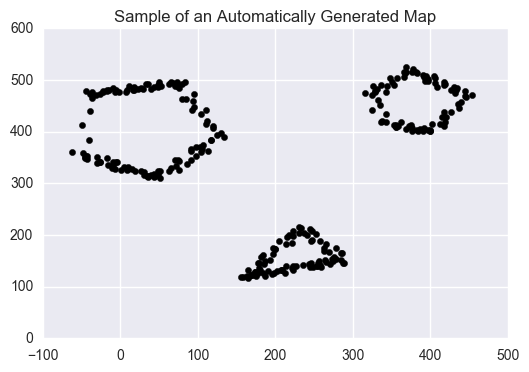

In [55]:
plt.scatter(all_points[:,0], all_points[:,1], color="black")
plt.title("Sample of an Automatically Generated Map")
plt.show()